# Project: Decoding Molecules From Fingerprints.
## Group Members:
### Qi Chen, e-mail: gusqichr@student.gu.se
### Nils Dunlop, e-mail: gusdunlni@student.gu.se
### Francisco Alejandro Erazo Piza, e-mail: guserafr@student.gu.se
***

In [77]:
import os
import io
import base64
from typing import List, Tuple
from concurrent.futures import ThreadPoolExecutor, as_completed

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors as mcolors
from PIL import Image

from rdkit import Chem
from rdkit.Chem import AllChem, Draw, PandasTools
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
from rdkit import DataStructs
from rdkit.DataStructs import TanimotoSimilarity

from joblib import Parallel, delayed
from sklearn.manifold import MDS, TSNE

# Pandas display settings
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)

### Define directories
***

In [78]:
# Set user directory
USER_DIR = os.path.expanduser('~')

# Set the project root directory
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Define the input and output directories
INPUT_DIR = os.path.join(PROJECT_ROOT, 'data/bit_flipping_nn_review_1')

### Load Parecoxib, Celecoxib, Cimicoxib and Deracoxib, Anitrazafen Data
***

In [79]:
# Read 10 random single flips
parecoxib_df_10 = pd.read_parquet(os.path.join(INPUT_DIR, 'parecoxib_df_10_random_single_flips.parquet'))
print(f"Parecoxib shape: {parecoxib_df_10.shape}")

celecoxib_df_10 = pd.read_parquet(os.path.join(INPUT_DIR, 'celecoxib_df_10_random_single_flips.parquet'))
print(f"Celecoxib shape: {celecoxib_df_10.shape}")

cimicoxib_df_10 = pd.read_parquet(os.path.join(INPUT_DIR, 'cimicoxib_df_10_random_single_flips.parquet'))
print(f"Cimicoxib shape: {cimicoxib_df_10.shape}")

deracoxib_df_10 = pd.read_parquet(os.path.join(INPUT_DIR, 'deracoxib_df_10_random_single_flips.parquet'))
print(f"Deracoxib shape: {deracoxib_df_10.shape}")

anitrazafen_df_10 = pd.read_parquet(os.path.join(INPUT_DIR, 'anitrazafen_df_10_random_single_flips.parquet'))
print(f"Anitrazafen shape: {anitrazafen_df_10.shape}")

Parecoxib shape: (10, 9)
Celecoxib shape: (10, 9)
Cimicoxib shape: (10, 9)
Deracoxib shape: (10, 9)
Anitrazafen shape: (10, 9)


In [80]:
# Read 100 random single flips
parecoxib_df_100 = pd.read_parquet(os.path.join(INPUT_DIR, 'parecoxib_df_100_random_single_flips.parquet'))
print(f"Parecoxib shape: {parecoxib_df_100.shape}")

celecoxib_df_100 = pd.read_parquet(os.path.join(INPUT_DIR, 'celecoxib_df_100_random_single_flips.parquet'))
print(f"Celecoxib shape: {celecoxib_df_100.shape}")

cimicoxib_df_100 = pd.read_parquet(os.path.join(INPUT_DIR, 'cimicoxib_df_100_random_single_flips.parquet'))
print(f"Cimicoxib shape: {cimicoxib_df_100.shape}")

deracoxib_df_100 = pd.read_parquet(os.path.join(INPUT_DIR, 'deracoxib_df_100_random_single_flips.parquet'))
print(f"Deracoxib shape: {deracoxib_df_100.shape}")

anitrazafen_df_100 = pd.read_parquet(os.path.join(INPUT_DIR, 'anitrazafen_df_100_random_single_flips.parquet'))
print(f"Anitrazafen shape: {anitrazafen_df_100.shape}")

Parecoxib shape: (100, 9)
Celecoxib shape: (100, 9)
Cimicoxib shape: (100, 9)
Deracoxib shape: (100, 9)
Anitrazafen shape: (100, 9)


In [81]:
# Read 1000 random single flips
parecoxib_df_1000 = pd.read_parquet(os.path.join(INPUT_DIR, 'parecoxib_df_1000_random_single_flips.parquet'))
print(f"Parecoxib shape: {parecoxib_df_1000.shape}")

celecoxib_df_1000 = pd.read_parquet(os.path.join(INPUT_DIR, 'celecoxib_df_1000_random_single_flips.parquet'))
print(f"Celecoxib shape: {celecoxib_df_1000.shape}")

cimicoxib_df_1000 = pd.read_parquet(os.path.join(INPUT_DIR, 'cimicoxib_df_1000_random_single_flips.parquet'))
print(f"Cimicoxib shape: {cimicoxib_df_1000.shape}")

deracoxib_df_1000 = pd.read_parquet(os.path.join(INPUT_DIR, 'deracoxib_df_1000_random_single_flips.parquet'))
print(f"Deracoxib shape: {deracoxib_df_1000.shape}")

anitrazafen_df_1000 = pd.read_parquet(os.path.join(INPUT_DIR, 'anitrazafen_df_1000_random_single_flips.parquet'))
print(f"Anitrazafen shape: {anitrazafen_df_1000.shape}")

Parecoxib shape: (1000, 9)
Celecoxib shape: (1000, 9)
Cimicoxib shape: (1000, 9)
Deracoxib shape: (1000, 9)
Anitrazafen shape: (1000, 9)


### Validate generated SMILES
***

In [82]:
# Function to convert SMILES to molecule and check validity
def smiles_to_mol(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return mol is not None, mol

In [83]:
# Validate generated SMILES
parecoxib_df_10['Valid_SMILES'], parecoxib_df_10['Molecule'] = zip(*parecoxib_df_10['Generated_SMILES'].apply(lambda x: smiles_to_mol(x)))
celecoxib_df_10['Valid_SMILES'], celecoxib_df_10['Molecule'] = zip(*celecoxib_df_10['Generated_SMILES'].apply(lambda x: smiles_to_mol(x)))
cimicoxib_df_10['Valid_SMILES'], cimicoxib_df_10['Molecule'] = zip(*cimicoxib_df_10['Generated_SMILES'].apply(lambda x: smiles_to_mol(x)))
deracoxib_df_10['Valid_SMILES'], deracoxib_df_10['Molecule'] = zip(*deracoxib_df_10['Generated_SMILES'].apply(lambda x: smiles_to_mol(x)))
anitrazafen_df_10['Valid_SMILES'], anitrazafen_df_10['Molecule'] = zip(*anitrazafen_df_10['Generated_SMILES'].apply(lambda x: smiles_to_mol(x)))

parecoxib_df_100['Valid_SMILES'], parecoxib_df_100['Molecule'] = zip(*parecoxib_df_100['Generated_SMILES'].apply(lambda x: smiles_to_mol(x)))
celecoxib_df_100['Valid_SMILES'], celecoxib_df_100['Molecule'] = zip(*celecoxib_df_100['Generated_SMILES'].apply(lambda x: smiles_to_mol(x)))
cimicoxib_df_100['Valid_SMILES'], cimicoxib_df_100['Molecule'] = zip(*cimicoxib_df_100['Generated_SMILES'].apply(lambda x: smiles_to_mol(x)))
deracoxib_df_100['Valid_SMILES'], deracoxib_df_100['Molecule'] = zip(*deracoxib_df_100['Generated_SMILES'].apply(lambda x: smiles_to_mol(x)))
anitrazafen_df_100['Valid_SMILES'], anitrazafen_df_100['Molecule'] = zip(*anitrazafen_df_100['Generated_SMILES'].apply(lambda x: smiles_to_mol(x)))

parecoxib_df_1000['Valid_SMILES'], parecoxib_df_1000['Molecule'] = zip(*parecoxib_df_1000['Generated_SMILES'].apply(lambda x: smiles_to_mol(x)))
celecoxib_df_1000['Valid_SMILES'], celecoxib_df_1000['Molecule'] = zip(*celecoxib_df_1000['Generated_SMILES'].apply(lambda x: smiles_to_mol(x)))
cimicoxib_df_1000['Valid_SMILES'], cimicoxib_df_1000['Molecule'] = zip(*cimicoxib_df_1000['Generated_SMILES'].apply(lambda x: smiles_to_mol(x)))
deracoxib_df_1000['Valid_SMILES'], deracoxib_df_1000['Molecule'] = zip(*deracoxib_df_1000['Generated_SMILES'].apply(lambda x: smiles_to_mol(x)))
anitrazafen_df_1000['Valid_SMILES'], anitrazafen_df_1000['Molecule'] = zip(*anitrazafen_df_1000['Generated_SMILES'].apply(lambda x: smiles_to_mol(x)))


In [84]:
def calculate_valid_smiles_percentage(df_dict):
    results = []
    
    for compound, df in df_dict.items():
        valid_smiles = df['Valid_SMILES'].sum()
        percentage = df['Valid_SMILES'].mean() * 100
        results.append({
            'Compound': compound,
            'Valid_SMILES': valid_smiles,
            'Percentage': percentage
        })
    
    return pd.DataFrame(results)

In [85]:
df_dict_10 = {
    'Parecoxib': parecoxib_df_10,
    'Celecoxib': celecoxib_df_10,
    'Cimicoxib': cimicoxib_df_10,
    'Deracoxib': deracoxib_df_10,
    'Anitrazafen': anitrazafen_df_10
}

valid_smiles_percentage_10 = calculate_valid_smiles_percentage(df_dict_10)
valid_smiles_percentage_10

Compound  Valid_SMILES  Percentage
0    Parecoxib            10       100.0
1    Celecoxib            10       100.0
2    Cimicoxib            10       100.0
3    Deracoxib            10       100.0
4  Anitrazafen            10       100.0

In [86]:
df_dict_100 = {
    'Parecoxib': parecoxib_df_100,
    'Celecoxib': celecoxib_df_100,
    'Cimicoxib': cimicoxib_df_100,
    'Deracoxib': deracoxib_df_100,
    'Anitrazafen': anitrazafen_df_100
}
valid_smiles_percentage_100 = calculate_valid_smiles_percentage(df_dict_100)
valid_smiles_percentage_100


Compound  Valid_SMILES  Percentage
0    Parecoxib           100       100.0
1    Celecoxib           100       100.0
2    Cimicoxib           100       100.0
3    Deracoxib           100       100.0
4  Anitrazafen           100       100.0

In [87]:
df_dict_1000 = {
    'Parecoxib': parecoxib_df_1000,
    'Celecoxib': celecoxib_df_1000,
    'Cimicoxib': cimicoxib_df_1000,
    'Deracoxib': deracoxib_df_1000,
    'Anitrazafen': anitrazafen_df_1000
}
valid_smiles_percentage_1000 = calculate_valid_smiles_percentage(df_dict_1000)
valid_smiles_percentage_1000

Compound  Valid_SMILES  Percentage
0    Parecoxib          1000       100.0
1    Celecoxib          1000       100.0
2    Cimicoxib          1000       100.0
3    Deracoxib          1000       100.0
4  Anitrazafen          1000       100.0

In [109]:
import requests

def get_molecule_name(smiles):
    url = "https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/smiles/{}/json".format(smiles)
    response = requests.get(url)
    
    if response.status_code == 200:
        data = response.json()
        print(data)
        print(data['PC_Compounds'][0]['props'][0]['value'])
        try:
            return data['PC_Compounds'][0]['props'][0]['value']['sval']
        except KeyError:
            return "Name not found"
    else:
        return "Invalid SMILES or no result"


In [110]:
parecoxib_df_10['Molecule_Name'] = parecoxib_df_10['Generated_SMILES'].apply(lambda x: get_molecule_name(x))
celecoxib_df_10['Molecule_Name'] = celecoxib_df_10['Generated_SMILES'].apply(lambda x: get_molecule_name(x))
cimicoxib_df_10['Molecule_Name'] = cimicoxib_df_10['Generated_SMILES'].apply(lambda x: get_molecule_name(x))
deracoxib_df_10['Molecule_Name'] = deracoxib_df_10['Generated_SMILES'].apply(lambda x: get_molecule_name(x))
anitrazafen_df_10['Molecule_Name'] = anitrazafen_df_10['Generated_SMILES'].apply(lambda x: get_molecule_name(x))

{'PC_Compounds': [{'id': {'id': {'cid': 119828}}, 'atoms': {'aid': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44], 'element': [16, 8, 8, 8, 8, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}, 'bonds': {'aid1': [1, 1, 1, 1, 2, 2, 5, 6, 6, 7, 8, 8, 8, 9, 9, 10, 10, 11, 12, 13, 13, 14, 14, 15, 16, 17, 17, 18, 18, 18, 19, 19, 20, 20, 21, 22, 22, 22, 23, 23, 24, 24, 25, 26, 26, 26], 'aid2': [3, 4, 6, 10, 7, 12, 21, 21, 31, 11, 9, 11, 12, 13, 14, 15, 16, 17, 18, 15, 27, 16, 28, 29, 30, 19, 20, 32, 33, 34, 23, 35, 24, 36, 22, 26, 37, 38, 25, 39, 25, 40, 41, 42, 43, 44], 'order': [2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1]}, 'coords': [{'type': [1, 5, 255], 'aid': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1

In [112]:
parecoxib_df_10

title                                         SMILES  \
0  Parecoxib  CCC(=O)NS(=O)(=O)c1ccc(cc1)c2c(C)onc2c3ccccc3   
1  Parecoxib  CCC(=O)NS(=O)(=O)c1ccc(cc1)c2c(C)onc2c3ccccc3   
2  Parecoxib  CCC(=O)NS(=O)(=O)c1ccc(cc1)c2c(C)onc2c3ccccc3   
3  Parecoxib  CCC(=O)NS(=O)(=O)c1ccc(cc1)c2c(C)onc2c3ccccc3   
4  Parecoxib  CCC(=O)NS(=O)(=O)c1ccc(cc1)c2c(C)onc2c3ccccc3   
5  Parecoxib  CCC(=O)NS(=O)(=O)c1ccc(cc1)c2c(C)onc2c3ccccc3   
6  Parecoxib  CCC(=O)NS(=O)(=O)c1ccc(cc1)c2c(C)onc2c3ccccc3   
7  Parecoxib  CCC(=O)NS(=O)(=O)c1ccc(cc1)c2c(C)onc2c3ccccc3   
8  Parecoxib  CCC(=O)NS(=O)(=O)c1ccc(cc1)c2c(C)onc2c3ccccc3   
9  Parecoxib  CCC(=O)NS(=O)(=O)c1ccc(cc1)c2c(C)onc2c3ccccc3   

                                                                                                                                                                                                                                                                                                     FingerprintBits  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]   
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]   
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]   
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]   
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]   
5  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]   
6  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]   
7  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]   
8  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]   
9  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

### Tanimoto similarity
***

In [88]:
# Define a function to calculate Tanimoto similarity with debugging
def calculate_tanimoto_safe(smiles1, smiles2):
    try:
        # Skip if either SMILES is marked as 'Invalid SMILES string'
        if smiles1 == 'Invalid SMILES string' or smiles2 == 'Invalid SMILES string':
            return None
        
        # Convert SMILES to molecule objects
        mol1 = Chem.MolFromSmiles(smiles1)
        mol2 = Chem.MolFromSmiles(smiles2)
        
        # Debugging information
        if mol1 is None:
            print(f"Failed to parse SMILES1: {smiles1}")
        if mol2 is None:
            print(f"Failed to parse SMILES2: {smiles2}")
        
        # Skip if either molecule failed to parse
        if mol1 is None or mol2 is None:
            return None
        
        # Generate fingerprints for Tanimoto calculation
        morgan_gen = GetMorganGenerator(radius=2, fpSize=2048)
        fp1 = morgan_gen.GetFingerprint(mol1)
        fp2 = morgan_gen.GetFingerprint(mol2)
        
        # Debugging information
        if fp1 is None or fp2 is None:
            print(f"Failed to generate fingerprints for SMILES1: {smiles1}, SMILES2: {smiles2}")
        
        # Calculate Tanimoto similarity
        return TanimotoSimilarity(fp1, fp2)
    
    except Exception as e:
        # Print the exception to help diagnose
        print(f"Error calculating Tanimoto similarity: {e}")
        return None

In [89]:
parecoxib_df_10['Tanimoto'] = parecoxib_df_10.apply(lambda row: calculate_tanimoto_safe(row['SMILES'], row['Generated_SMILES']), axis=1)
celecoxib_df_10['Tanimoto'] = celecoxib_df_10.apply(lambda row: calculate_tanimoto_safe(row['SMILES'], row['Generated_SMILES']), axis=1)
cimicoxib_df_10['Tanimoto'] = cimicoxib_df_10.apply(lambda row: calculate_tanimoto_safe(row['SMILES'], row['Generated_SMILES']), axis=1)
deracoxib_df_10['Tanimoto'] = deracoxib_df_10.apply(lambda row: calculate_tanimoto_safe(row['SMILES'], row['Generated_SMILES']), axis=1)
anitrazafen_df_10['Tanimoto'] = anitrazafen_df_10.apply(lambda row: calculate_tanimoto_safe(row['SMILES'], row['Generated_SMILES']), axis=1)

parecoxib_df_100['Tanimoto'] = parecoxib_df_100.apply(lambda row: calculate_tanimoto_safe(row['SMILES'], row['Generated_SMILES']), axis=1)
celecoxib_df_100['Tanimoto'] = celecoxib_df_100.apply(lambda row: calculate_tanimoto_safe(row['SMILES'], row['Generated_SMILES']), axis=1)
cimicoxib_df_100['Tanimoto'] = cimicoxib_df_100.apply(lambda row: calculate_tanimoto_safe(row['SMILES'], row['Generated_SMILES']), axis=1)
deracoxib_df_100['Tanimoto'] = deracoxib_df_100.apply(lambda row: calculate_tanimoto_safe(row['SMILES'], row['Generated_SMILES']), axis=1)
anitrazafen_df_100['Tanimoto'] = anitrazafen_df_100.apply(lambda row: calculate_tanimoto_safe(row['SMILES'], row['Generated_SMILES']), axis=1)

parecoxib_df_1000['Tanimoto'] = parecoxib_df_1000.apply(lambda row: calculate_tanimoto_safe(row['SMILES'], row['Generated_SMILES']), axis=1)
celecoxib_df_1000['Tanimoto'] = celecoxib_df_1000.apply(lambda row: calculate_tanimoto_safe(row['SMILES'], row['Generated_SMILES']), axis=1)
cimicoxib_df_1000['Tanimoto'] = cimicoxib_df_1000.apply(lambda row: calculate_tanimoto_safe(row['SMILES'], row['Generated_SMILES']), axis=1)
deracoxib_df_1000['Tanimoto'] = deracoxib_df_1000.apply(lambda row: calculate_tanimoto_safe(row['SMILES'], row['Generated_SMILES']), axis=1)
anitrazafen_df_1000['Tanimoto'] = anitrazafen_df_1000.apply(lambda row: calculate_tanimoto_safe(row['SMILES'], row['Generated_SMILES']), axis=1)

In [90]:
average_similarity_parecoxib_10 = parecoxib_df_10['Tanimoto'].mean()
average_similarity_celecoxib_10 = celecoxib_df_10['Tanimoto'].mean()
average_similarity_cimicoxib_10 = cimicoxib_df_10['Tanimoto'].mean()
average_similarity_deracoxib_10 = deracoxib_df_10['Tanimoto'].mean()
average_similarity_anitrazafen_10 = anitrazafen_df_10['Tanimoto'].mean()
print('*** 10 random single flips ***')
print(f"Average Tanimoto Similarity for 10 random single flips Parecoxib: {average_similarity_parecoxib_10}")
print(f"Average Tanimoto Similarity for 10 random single flips Celecoxib: {average_similarity_celecoxib_10}")
print(f"Average Tanimoto Similarity for 10 random single flips Cimicoxib: {average_similarity_cimicoxib_10}")
print(f"Average Tanimoto Similarity for 10 random single flips Deracoxib: {average_similarity_deracoxib_10}")
print(f"Average Tanimoto Similarity for 10 random single flips Anitrazafen: {average_similarity_anitrazafen_10}")

average_similarity_parecoxib_100 = parecoxib_df_100['Tanimoto'].mean()
average_similarity_celecoxib_100 = celecoxib_df_100['Tanimoto'].mean()
average_similarity_cimicoxib_100 = cimicoxib_df_100['Tanimoto'].mean()
average_similarity_deracoxib_100 = deracoxib_df_100['Tanimoto'].mean()
average_similarity_anitrazafen_100 = anitrazafen_df_100['Tanimoto'].mean()
print('*** 100 random single flips ***')
print(f"Average Tanimoto Similarity for 100 random single flips Parecoxib: {average_similarity_parecoxib_100}")
print(f"Average Tanimoto Similarity for 100 random single flips Celecoxib: {average_similarity_celecoxib_100}")
print(f"Average Tanimoto Similarity for 100 random single flips Cimicoxib: {average_similarity_cimicoxib_100}")
print(f"Average Tanimoto Similarity for 100 random single flips Deracoxib: {average_similarity_deracoxib_100}")
print(f"Average Tanimoto Similarity for 100 random single flips Anitrazafen: {average_similarity_anitrazafen_100}")

average_similarity_parecoxib_1000 = parecoxib_df_1000['Tanimoto'].mean()
average_similarity_celecoxib_1000 = celecoxib_df_1000['Tanimoto'].mean()
average_similarity_cimicoxib_1000 = cimicoxib_df_1000['Tanimoto'].mean()
average_similarity_deracoxib_1000 = deracoxib_df_1000['Tanimoto'].mean()
average_similarity_anitrazafen_1000 = anitrazafen_df_1000['Tanimoto'].mean()
print('*** 1000 random single flips ***')
print(f"Average Tanimoto Similarity for 1000 random single flips Parecoxib: {average_similarity_parecoxib_1000}")
print(f"Average Tanimoto Similarity for 1000 random single flips Celecoxib: {average_similarity_celecoxib_1000}")
print(f"Average Tanimoto Similarity for 1000 random single flips Cimicoxib: {average_similarity_cimicoxib_1000}")
print(f"Average Tanimoto Similarity for 1000 random single flips Deracoxib: {average_similarity_deracoxib_1000}")
print(f"Average Tanimoto Similarity for 1000 random single flips Anitrazafen: {average_similarity_anitrazafen_1000}")
#Similarity plot

*** 10 random single flips ***
Average Tanimoto Similarity for 10 random single flips Parecoxib: 1.0
Average Tanimoto Similarity for 10 random single flips Celecoxib: 1.0
Average Tanimoto Similarity for 10 random single flips Cimicoxib: 1.0
Average Tanimoto Similarity for 10 random single flips Deracoxib: 1.0
Average Tanimoto Similarity for 10 random single flips Anitrazafen: 1.0
*** 100 random single flips ***
Average Tanimoto Similarity for 100 random single flips Parecoxib: 1.0
Average Tanimoto Similarity for 100 random single flips Celecoxib: 1.0
Average Tanimoto Similarity for 100 random single flips Cimicoxib: 1.0
Average Tanimoto Similarity for 100 random single flips Deracoxib: 1.0
Average Tanimoto Similarity for 100 random single flips Anitrazafen: 1.0
*** 1000 random single flips ***
Average Tanimoto Similarity for 1000 random single flips Parecoxib: 0.9997292517006803
Average Tanimoto Similarity for 1000 random single flips Celecoxib: 1.0
Average Tanimoto Similarity for 1000

In [91]:
tanimoto_matches_parecoxib_10 = (parecoxib_df_10['Tanimoto'] == 1.0).sum()
tanimoto_matches_celecoxib_10 = (celecoxib_df_10['Tanimoto'] == 1.0).sum()
tanimoto_matches_cimicoxib_10 = (cimicoxib_df_10['Tanimoto'] == 1.0).sum()
tanimoto_matches_deracoxib_10 = (deracoxib_df_10['Tanimoto'] == 1.0).sum()
tanimoto_matches_anitrazafen_10 = (anitrazafen_df_10['Tanimoto'] == 1.0).sum()
print(f"Tanimoto Accuracy for 10 random single flips Parecoxib: {tanimoto_matches_parecoxib_10 / len(parecoxib_df_10):.2%}")
print(f"Tanimoto Accuracy for 10 random single flips Celecoxib: {tanimoto_matches_celecoxib_10 / len(celecoxib_df_10):.2%}")
print(f"Tanimoto Accuracy for 10 random single flips Cimicoxib: {tanimoto_matches_cimicoxib_10 / len(cimicoxib_df_10):.2%}")
print(f"Tanimoto Accuracy for 10 random single flips Deracoxib: {tanimoto_matches_deracoxib_10 / len(deracoxib_df_10):.2%}")
print(f"Tanimoto Accuracy for 10 random single flips Anitrazafen: {tanimoto_matches_anitrazafen_10 / len(anitrazafen_df_10):.2%}")
print('')

tanimoto_matches_parecoxib_100 = (parecoxib_df_100['Tanimoto'] == 1.0).sum()
tanimoto_matches_celecoxib_100 = (celecoxib_df_100['Tanimoto'] == 1.0).sum()
tanimoto_matches_cimicoxib_100 = (cimicoxib_df_100['Tanimoto'] == 1.0).sum()
tanimoto_matches_deracoxib_100 = (deracoxib_df_100['Tanimoto'] == 1.0).sum()
tanimoto_matches_anitrazafen_100 = (anitrazafen_df_100['Tanimoto'] == 1.0).sum()
print(f"Tanimoto Accuracy for 100 random single flips Parecoxib: {tanimoto_matches_parecoxib_100 / len(parecoxib_df_100):.2%}")
print(f"Tanimoto Accuracy for 100 random single flips Celecoxib: {tanimoto_matches_celecoxib_100 / len(celecoxib_df_100):.2%}")
print(f"Tanimoto Accuracy for 100 random single flips Cimicoxib: {tanimoto_matches_cimicoxib_100 / len(cimicoxib_df_100):.2%}")
print(f"Tanimoto Accuracy for 100 random single flips Deracoxib: {tanimoto_matches_deracoxib_100 / len(deracoxib_df_100):.2%}")
print(f"Tanimoto Accuracy for 100 random single flips Anitrazafen: {tanimoto_matches_anitrazafen_100 / len(anitrazafen_df_100):.2%}")
print('')

tanimoto_matches_parecoxib_1000 = (parecoxib_df_1000['Tanimoto'] == 1.0).sum()
tanimoto_matches_celecoxib_1000 = (celecoxib_df_1000['Tanimoto'] == 1.0).sum()
tanimoto_matches_cimicoxib_1000 = (cimicoxib_df_1000['Tanimoto'] == 1.0).sum()
tanimoto_matches_deracoxib_1000 = (deracoxib_df_1000['Tanimoto'] == 1.0).sum()
tanimoto_matches_anitrazafen_1000 = (anitrazafen_df_1000['Tanimoto'] == 1.0).sum()
print(f"Tanimoto Accuracy for 1000 random single flips Parecoxib: {tanimoto_matches_parecoxib_1000 / len(parecoxib_df_1000):.2%}")
print(f"Tanimoto Accuracy for 1000 random single flips Celecoxib: {tanimoto_matches_celecoxib_1000 / len(celecoxib_df_1000):.2%}")
print(f"Tanimoto Accuracy for 1000 random single flips Cimicoxib: {tanimoto_matches_cimicoxib_1000 / len(cimicoxib_df_1000):.2%}")
print(f"Tanimoto Accuracy for 1000 random single flips Deracoxib: {tanimoto_matches_deracoxib_1000 / len(deracoxib_df_1000):.2%}")
print(f"Tanimoto Accuracy for 1000 random single flips Anitrazafen: {tanimoto_matches_anitrazafen_1000 / len(anitrazafen_df_1000):.2%}")


Tanimoto Accuracy for 10 random single flips Parecoxib: 100.00%
Tanimoto Accuracy for 10 random single flips Celecoxib: 100.00%
Tanimoto Accuracy for 10 random single flips Cimicoxib: 100.00%
Tanimoto Accuracy for 10 random single flips Deracoxib: 100.00%
Tanimoto Accuracy for 10 random single flips Anitrazafen: 100.00%

Tanimoto Accuracy for 100 random single flips Parecoxib: 100.00%
Tanimoto Accuracy for 100 random single flips Celecoxib: 100.00%
Tanimoto Accuracy for 100 random single flips Cimicoxib: 100.00%
Tanimoto Accuracy for 100 random single flips Deracoxib: 100.00%
Tanimoto Accuracy for 100 random single flips Anitrazafen: 100.00%

Tanimoto Accuracy for 1000 random single flips Parecoxib: 99.80%
Tanimoto Accuracy for 1000 random single flips Celecoxib: 100.00%
Tanimoto Accuracy for 1000 random single flips Cimicoxib: 100.00%
Tanimoto Accuracy for 1000 random single flips Deracoxib: 100.00%
Tanimoto Accuracy for 1000 random single flips Anitrazafen: 99.00%


In [92]:
def plot_similarity_distribution(df, molecule_name, n_flips):
    plt.figure(figsize=(10, 6))
    sns.histplot(df['Tanimoto'], bins=20, kde=True)
    plt.title(f'Similarity Distribution of Generated Molecules\n{molecule_name} ({n_flips} flips)')
    plt.xlabel('Tanimoto Similarity')
    plt.ylabel('Count')
    plt.show()

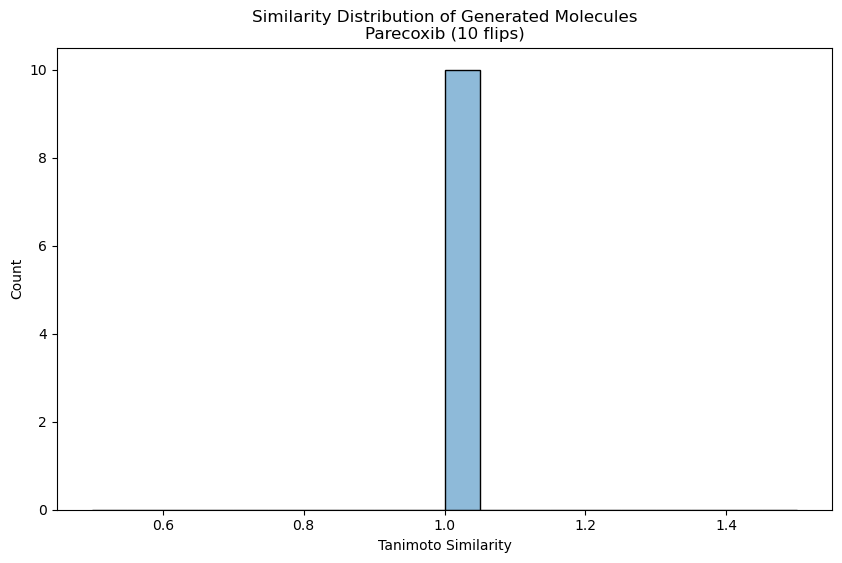

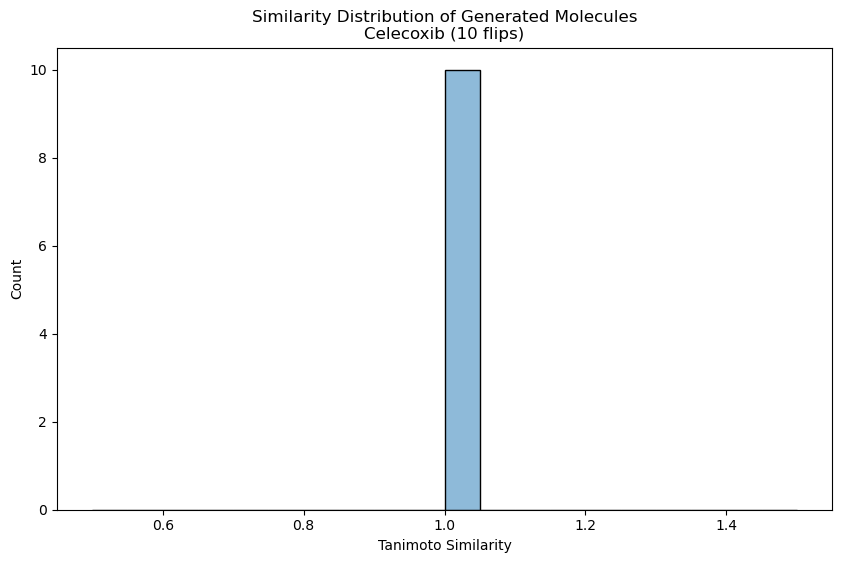

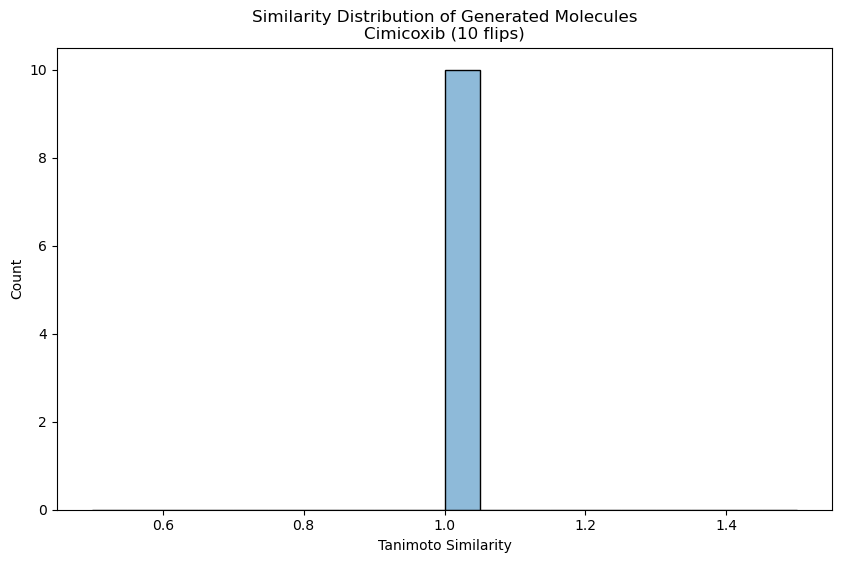

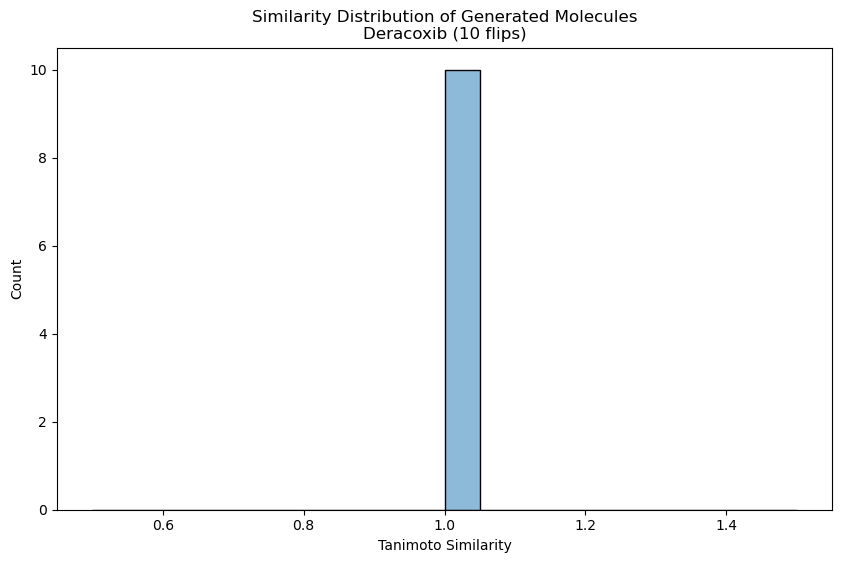

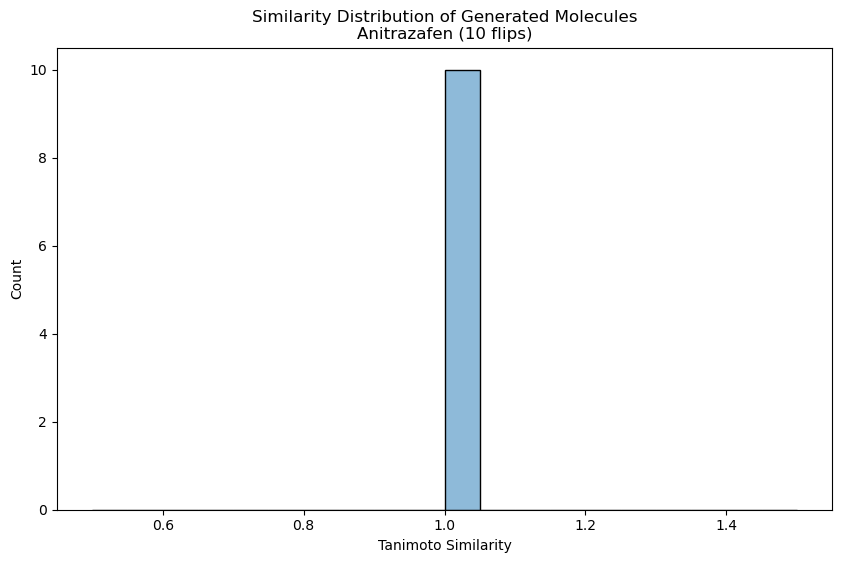

In [93]:
plot_similarity_distribution(parecoxib_df_10, 'Parecoxib', 10)
plot_similarity_distribution(celecoxib_df_10, 'Celecoxib', 10)
plot_similarity_distribution(cimicoxib_df_10, 'Cimicoxib', 10)
plot_similarity_distribution(deracoxib_df_10, 'Deracoxib', 10)
plot_similarity_distribution(anitrazafen_df_10, 'Anitrazafen', 10)

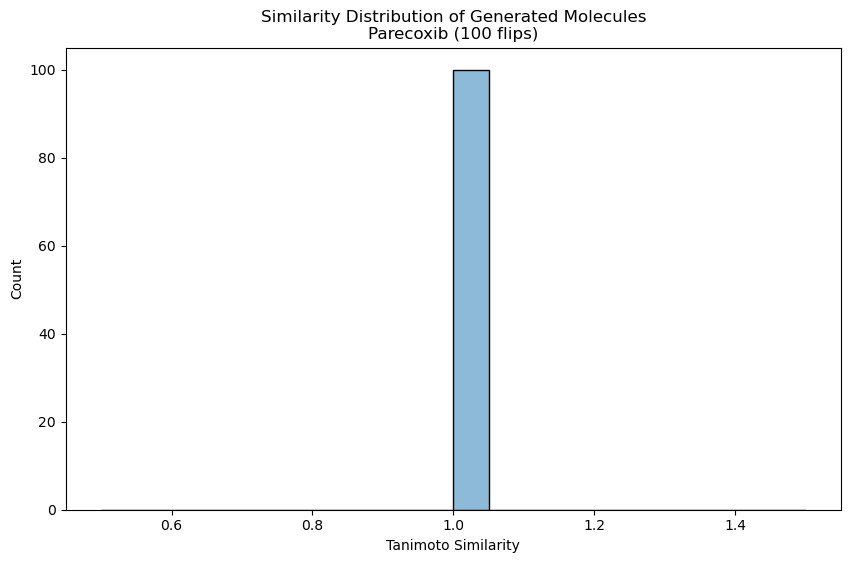

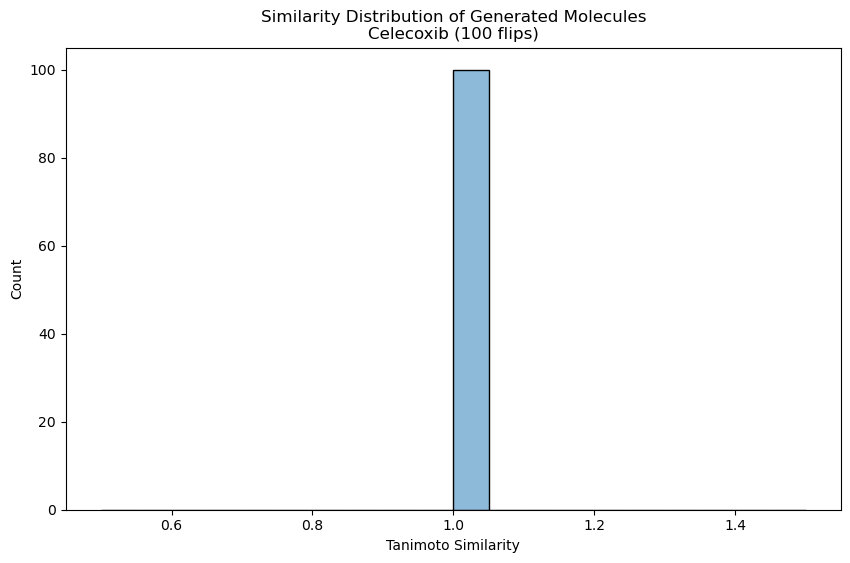

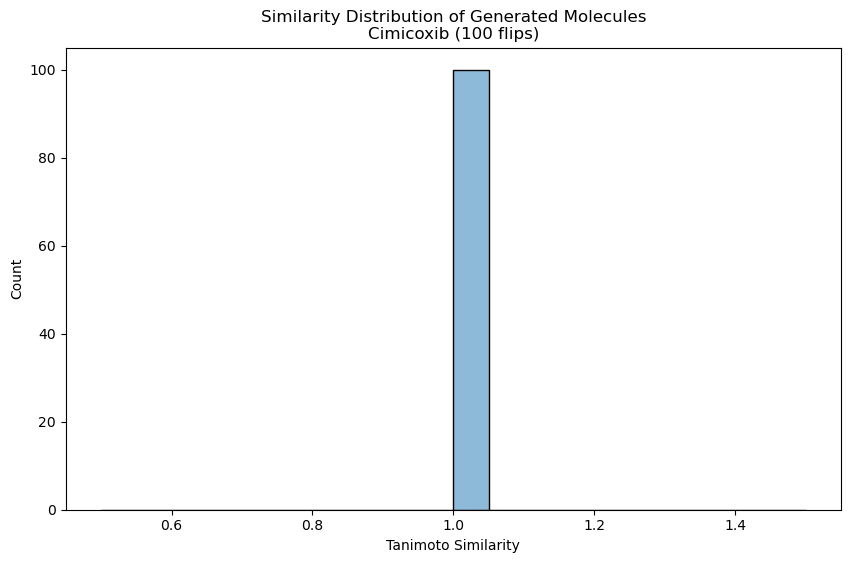

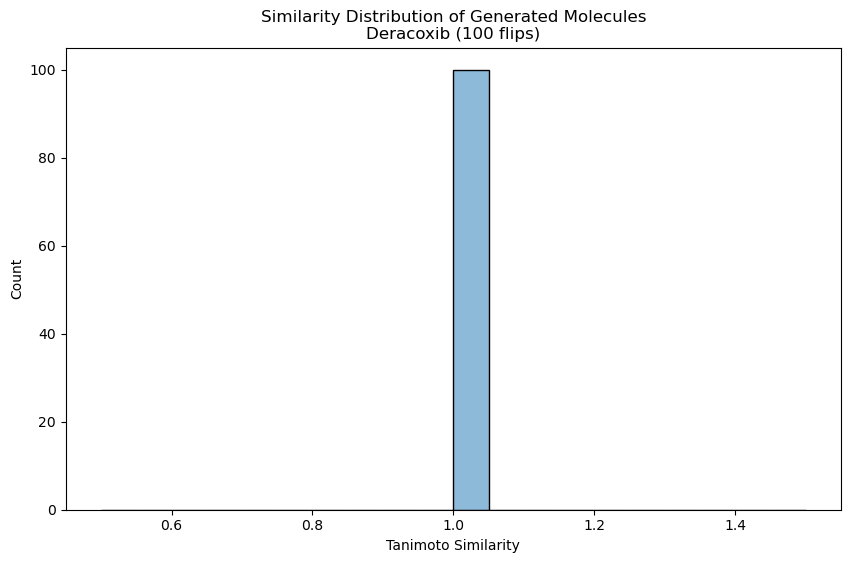

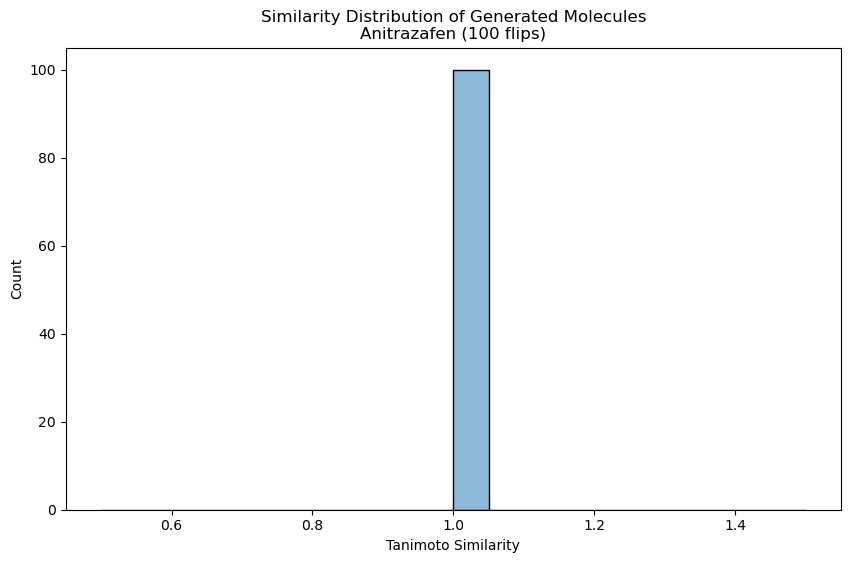

In [94]:
plot_similarity_distribution(parecoxib_df_100, 'Parecoxib', 100)
plot_similarity_distribution(celecoxib_df_100, 'Celecoxib', 100)
plot_similarity_distribution(cimicoxib_df_100, 'Cimicoxib', 100)
plot_similarity_distribution(deracoxib_df_100, 'Deracoxib', 100)
plot_similarity_distribution(anitrazafen_df_100, 'Anitrazafen', 100)

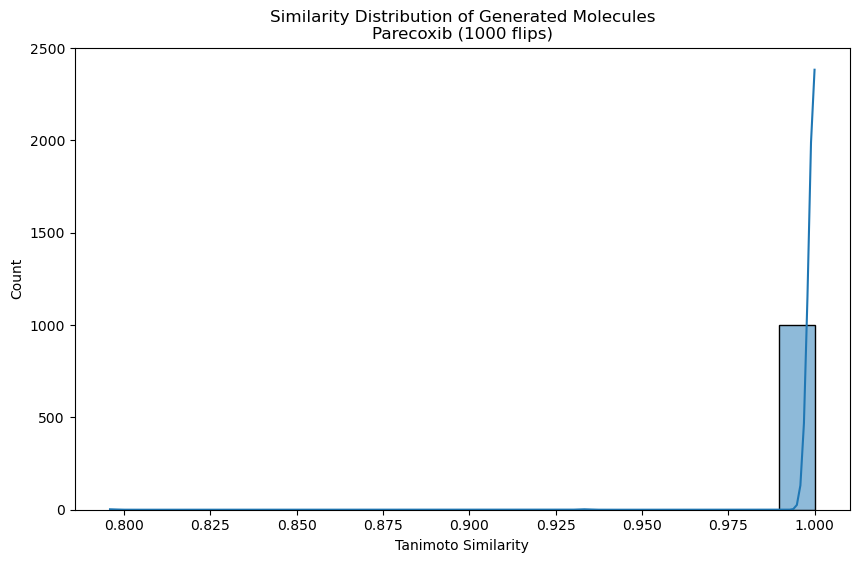

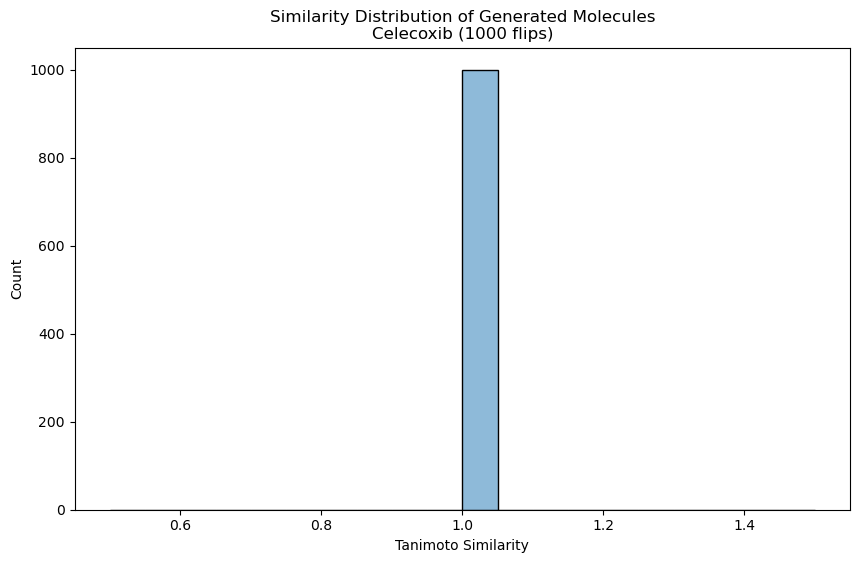

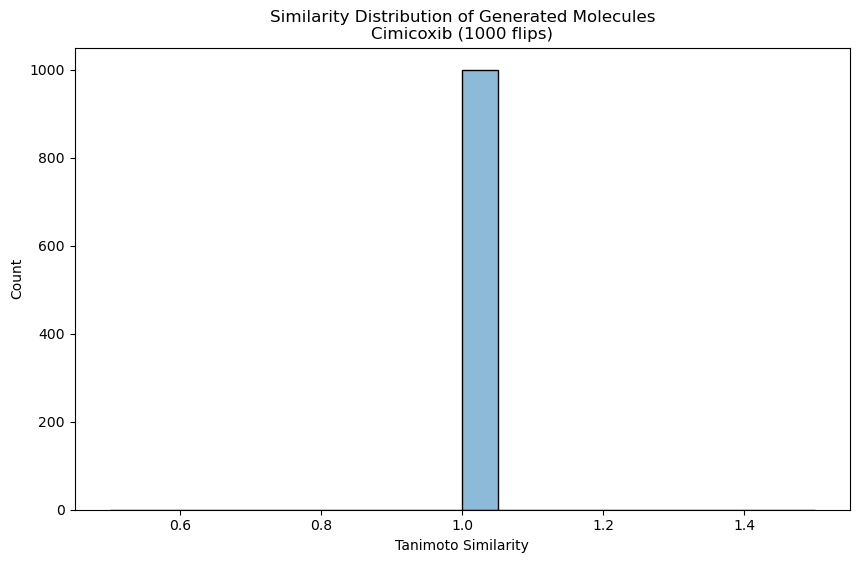

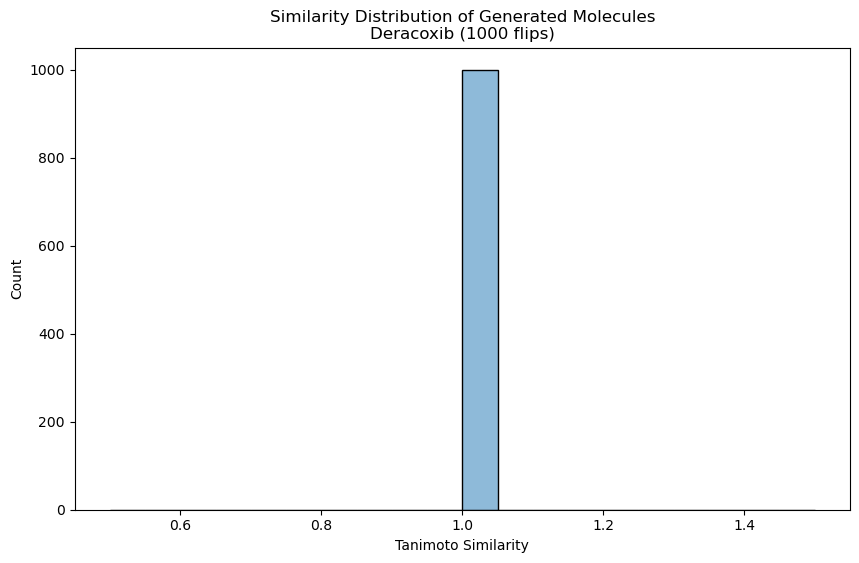

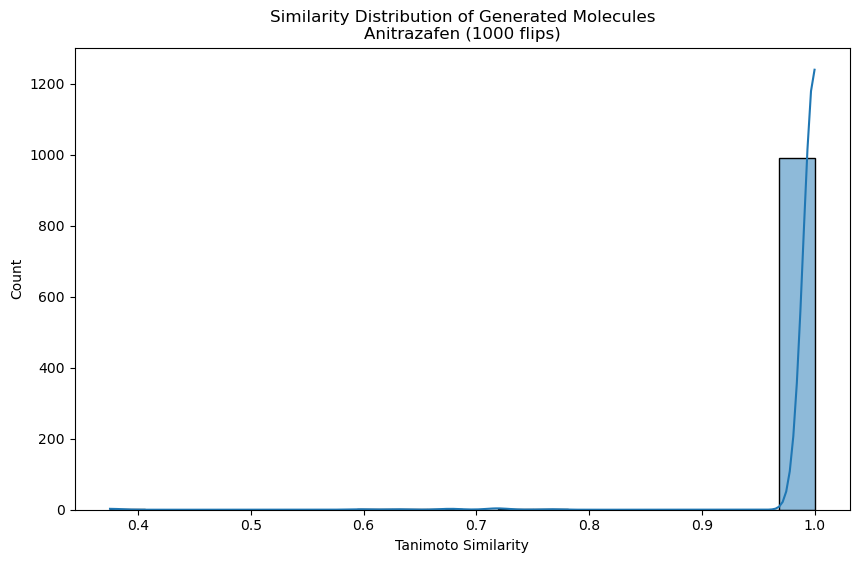

In [95]:
plot_similarity_distribution(parecoxib_df_1000, 'Parecoxib', 1000)
plot_similarity_distribution(celecoxib_df_1000, 'Celecoxib', 1000)
plot_similarity_distribution(cimicoxib_df_1000, 'Cimicoxib', 1000)
plot_similarity_distribution(deracoxib_df_1000, 'Deracoxib', 1000)
plot_similarity_distribution(anitrazafen_df_1000, 'Anitrazafen', 1000)

### Compare canonical SMILES
***

In [96]:
def compare_canonical_smiles(smiles1, smiles2):
    try:
        mol1 = Chem.MolFromSmiles(smiles1)
        mol2 = Chem.MolFromSmiles(smiles2)
        
        if mol1 is None:
            return {'match': False, 'reason': f"Invalid SMILES 1: {smiles1}"}
        if mol2 is None:
            return {'match': False, 'reason': f"Invalid SMILES 2: {smiles2}"}
        
        canonical_smiles1 = Chem.MolToSmiles(mol1, isomericSmiles=True, canonical=True)
        canonical_smiles2 = Chem.MolToSmiles(mol2, isomericSmiles=True, canonical=True)
        
        if canonical_smiles1 == canonical_smiles2:
            return {'match': True, 'canonical_smiles': canonical_smiles1}
        else:
            return {'match': False, 'reason': "Canonical SMILES do not match",
                    'canonical_smiles1': canonical_smiles1,
                    'canonical_smiles2': canonical_smiles2}
    except Exception as e:
        return {'match': False, 'reason': f"Error during comparison: {str(e)}"}

In [97]:
parecoxib_df_10['Canonical_Match'] = parecoxib_df_10.apply(lambda row: compare_canonical_smiles(row['SMILES'], row['Generated_SMILES']), axis=1)
celecoxib_df_10['Canonical_Match'] = celecoxib_df_10.apply(lambda row: compare_canonical_smiles(row['SMILES'], row['Generated_SMILES']), axis=1)
cimicoxib_df_10['Canonical_Match'] = cimicoxib_df_10.apply(lambda row: compare_canonical_smiles(row['SMILES'], row['Generated_SMILES']), axis=1)
deracoxib_df_10['Canonical_Match'] = deracoxib_df_10.apply(lambda row: compare_canonical_smiles(row['SMILES'], row['Generated_SMILES']), axis=1)
anitrazafen_df_10['Canonical_Match'] = anitrazafen_df_10.apply(lambda row: compare_canonical_smiles(row['SMILES'], row['Generated_SMILES']), axis=1)

parecoxib_df_100['Canonical_Match'] = parecoxib_df_100.apply(lambda row: compare_canonical_smiles(row['SMILES'], row['Generated_SMILES']), axis=1)
celecoxib_df_100['Canonical_Match'] = celecoxib_df_100.apply(lambda row: compare_canonical_smiles(row['SMILES'], row['Generated_SMILES']), axis=1)
cimicoxib_df_100['Canonical_Match'] = cimicoxib_df_100.apply(lambda row: compare_canonical_smiles(row['SMILES'], row['Generated_SMILES']), axis=1)
deracoxib_df_100['Canonical_Match'] = deracoxib_df_100.apply(lambda row: compare_canonical_smiles(row['SMILES'], row['Generated_SMILES']), axis=1)
anitrazafen_df_100['Canonical_Match'] = anitrazafen_df_100.apply(lambda row: compare_canonical_smiles(row['SMILES'], row['Generated_SMILES']), axis=1)

parecoxib_df_1000['Canonical_Match'] = parecoxib_df_1000.apply(lambda row: compare_canonical_smiles(row['SMILES'], row['Generated_SMILES']), axis=1)
celecoxib_df_1000['Canonical_Match'] = celecoxib_df_1000.apply(lambda row: compare_canonical_smiles(row['SMILES'], row['Generated_SMILES']), axis=1)
cimicoxib_df_1000['Canonical_Match'] = cimicoxib_df_1000.apply(lambda row: compare_canonical_smiles(row['SMILES'], row['Generated_SMILES']), axis=1)
deracoxib_df_1000['Canonical_Match'] = deracoxib_df_1000.apply(lambda row: compare_canonical_smiles(row['SMILES'], row['Generated_SMILES']), axis=1)
anitrazafen_df_1000['Canonical_Match'] = anitrazafen_df_1000.apply(lambda row: compare_canonical_smiles(row['SMILES'], row['Generated_SMILES']), axis=1)


In [98]:
canonical_matches_parecoxib_10 = parecoxib_df_10['Canonical_Match'].apply(lambda x: x['match']).sum()
canonical_matches_celecoxib_10 = celecoxib_df_10['Canonical_Match'].apply(lambda x: x['match']).sum()
canonical_matches_cimicoxib_10 = cimicoxib_df_10['Canonical_Match'].apply(lambda x: x['match']).sum()
canonical_matches_deracoxib_10 = deracoxib_df_10['Canonical_Match'].apply(lambda x: x['match']).sum()
canonical_matches_anitrazafen_10 = anitrazafen_df_10['Canonical_Match'].apply(lambda x: x['match']).sum()

canonical_matches_parecoxib_100 = parecoxib_df_100['Canonical_Match'].apply(lambda x: x['match']).sum()
canonical_matches_celecoxib_100 = celecoxib_df_100['Canonical_Match'].apply(lambda x: x['match']).sum()
canonical_matches_cimicoxib_100 = cimicoxib_df_100['Canonical_Match'].apply(lambda x: x['match']).sum()
canonical_matches_deracoxib_100 = deracoxib_df_100['Canonical_Match'].apply(lambda x: x['match']).sum()
canonical_matches_anitrazafen_100 = anitrazafen_df_100['Canonical_Match'].apply(lambda x: x['match']).sum()

canonical_matches_parecoxib_1000 = parecoxib_df_1000['Canonical_Match'].apply(lambda x: x['match']).sum()
canonical_matches_celecoxib_1000 = celecoxib_df_1000['Canonical_Match'].apply(lambda x: x['match']).sum()
canonical_matches_cimicoxib_1000 = cimicoxib_df_1000['Canonical_Match'].apply(lambda x: x['match']).sum()
canonical_matches_deracoxib_1000 = deracoxib_df_1000['Canonical_Match'].apply(lambda x: x['match']).sum()
canonical_matches_anitrazafen_1000 = anitrazafen_df_1000['Canonical_Match'].apply(lambda x: x['match']).sum()

print("**** Parecoxib ****")
print(f"Canonical SMILES Match Accuracy 10 random single flips: {canonical_matches_parecoxib_10 / len(parecoxib_df_10):.2%}")
print(f"Canonical SMILES Match Accuracy 100 random single flips: {canonical_matches_parecoxib_100 / len(parecoxib_df_100):.2%}")
print(f"Canonical SMILES Match Accuracy 1000 random single flips: {canonical_matches_parecoxib_1000 / len(parecoxib_df_1000):.2%}")

print("**** Celecoxib ****")
print(f"Canonical SMILES Match Accuracy 10 random single flips: {canonical_matches_celecoxib_10 / len(celecoxib_df_10):.2%}")
print(f"Canonical SMILES Match Accuracy 100 random single flips: {canonical_matches_celecoxib_100 / len(celecoxib_df_100):.2%}")
print(f"Canonical SMILES Match Accuracy 1000 random single flips: {canonical_matches_celecoxib_1000 / len(celecoxib_df_1000):.2%}")

print("**** Cimicoxib ****")
print(f"Canonical SMILES Match Accuracy 10 random single flips: {canonical_matches_cimicoxib_10 / len(cimicoxib_df_10):.2%}")
print(f"Canonical SMILES Match Accuracy 100 random single flips: {canonical_matches_cimicoxib_100 / len(cimicoxib_df_100):.2%}")
print(f"Canonical SMILES Match Accuracy 1000 random single flips: {canonical_matches_cimicoxib_1000 / len(cimicoxib_df_1000):.2%}")

print("**** Deracoxib ****")
print(f"Canonical SMILES Match Accuracy 10 random single flips: {canonical_matches_deracoxib_10 / len(deracoxib_df_10):.2%}")
print(f"Canonical SMILES Match Accuracy 100 random single flips: {canonical_matches_deracoxib_100 / len(deracoxib_df_100):.2%}")
print(f"Canonical SMILES Match Accuracy 1000 random single flips: {canonical_matches_deracoxib_1000 / len(deracoxib_df_1000):.2%}")

print("**** Anitrazafen ****")
print(f"Canonical SMILES Match Accuracy 10 random single flips: {canonical_matches_anitrazafen_10 / len(anitrazafen_df_10):.2%}")
print(f"Canonical SMILES Match Accuracy 100 random single flips: {canonical_matches_anitrazafen_100 / len(anitrazafen_df_100):.2%}")
print(f"Canonical SMILES Match Accuracy 1000 random single flips: {canonical_matches_anitrazafen_1000 / len(anitrazafen_df_1000):.2%}")


**** Parecoxib ****
Canonical SMILES Match Accuracy 10 random single flips: 100.00%
Canonical SMILES Match Accuracy 100 random single flips: 100.00%
Canonical SMILES Match Accuracy 1000 random single flips: 99.40%
**** Celecoxib ****
Canonical SMILES Match Accuracy 10 random single flips: 100.00%
Canonical SMILES Match Accuracy 100 random single flips: 100.00%
Canonical SMILES Match Accuracy 1000 random single flips: 100.00%
**** Cimicoxib ****
Canonical SMILES Match Accuracy 10 random single flips: 100.00%
Canonical SMILES Match Accuracy 100 random single flips: 100.00%
Canonical SMILES Match Accuracy 1000 random single flips: 100.00%
**** Deracoxib ****
Canonical SMILES Match Accuracy 10 random single flips: 100.00%
Canonical SMILES Match Accuracy 100 random single flips: 100.00%
Canonical SMILES Match Accuracy 1000 random single flips: 100.00%
**** Anitrazafen ****
Canonical SMILES Match Accuracy 10 random single flips: 100.00%
Canonical SMILES Match Accuracy 100 random single flips

### Compare raw SMILES
***

In [99]:
raw_smiles_matches_parecoxib_10 = parecoxib_df_10.apply(lambda row: row['SMILES'] == row['Generated_SMILES'], axis=1)
raw_smiles_matches_parecoxib_100 = parecoxib_df_100.apply(lambda row: row['SMILES'] == row['Generated_SMILES'], axis=1)
raw_smiles_matches_parecoxib_1000 = parecoxib_df_1000.apply(lambda row: row['SMILES'] == row['Generated_SMILES'], axis=1)
print("**** Parecoxib ****")
print(f"Raw SMILES Match Accuracy 10 random single flips: {raw_smiles_matches_parecoxib_10.mean():.2%}")
print(f"Raw SMILES Match Accuracy 100 random single flips: {raw_smiles_matches_parecoxib_100.mean():.2%}")
print(f"Raw SMILES Match Accuracy 1000 random single flips: {raw_smiles_matches_parecoxib_1000.mean():.2%}")

raw_smiles_matches_celecoxib_10 = celecoxib_df_10.apply(lambda row: row['SMILES'] == row['Generated_SMILES'], axis=1)
raw_smiles_matches_celecoxib_100 = celecoxib_df_100.apply(lambda row: row['SMILES'] == row['Generated_SMILES'], axis=1)
raw_smiles_matches_celecoxib_1000 = celecoxib_df_1000.apply(lambda row: row['SMILES'] == row['Generated_SMILES'], axis=1)
print("**** Celecoxib ****")
print(f"Raw SMILES Match Accuracy 10 random single flips: {raw_smiles_matches_celecoxib_10.mean():.2%}")
print(f"Raw SMILES Match Accuracy 100 random single flips: {raw_smiles_matches_celecoxib_100.mean():.2%}")
print(f"Raw SMILES Match Accuracy 1000 random single flips: {raw_smiles_matches_celecoxib_1000.mean():.2%}")


raw_smiles_matches_cimicoxib_10 = cimicoxib_df_10.apply(lambda row: row['SMILES'] == row['Generated_SMILES'], axis=1)
raw_smiles_matches_cimicoxib_100 = cimicoxib_df_100.apply(lambda row: row['SMILES'] == row['Generated_SMILES'], axis=1)
raw_smiles_matches_cimicoxib_1000 = cimicoxib_df_1000.apply(lambda row: row['SMILES'] == row['Generated_SMILES'], axis=1)
print("**** Cimicoxib ****")
print(f"Raw SMILES Match Accuracy 10 random single flips: {raw_smiles_matches_cimicoxib_10.mean():.2%}")
print(f"Raw SMILES Match Accuracy 100 random single flips: {raw_smiles_matches_cimicoxib_100.mean():.2%}")
print(f"Raw SMILES Match Accuracy 1000 random single flips: {raw_smiles_matches_cimicoxib_1000.mean():.2%}")


raw_smiles_matches_deracoxib_10 = deracoxib_df_10.apply(lambda row: row['SMILES'] == row['Generated_SMILES'], axis=1)
raw_smiles_matches_deracoxib_100 = deracoxib_df_100.apply(lambda row: row['SMILES'] == row['Generated_SMILES'], axis=1)
raw_smiles_matches_deracoxib_1000 = deracoxib_df_1000.apply(lambda row: row['SMILES'] == row['Generated_SMILES'], axis=1)
print("**** Deracoxib ****")
print(f"Raw SMILES Match Accuracy 10 random single flips: {raw_smiles_matches_deracoxib_10.mean():.2%}")
print(f"Raw SMILES Match Accuracy 100 random single flips: {raw_smiles_matches_deracoxib_100.mean():.2%}")
print(f"Raw SMILES Match Accuracy 1000 random single flips: {raw_smiles_matches_deracoxib_1000.mean():.2%}")


raw_smiles_matches_anitrazafen_10 = anitrazafen_df_10.apply(lambda row: row['SMILES'] == row['Generated_SMILES'], axis=1)
raw_smiles_matches_anitrazafen_100 = anitrazafen_df_100.apply(lambda row: row['SMILES'] == row['Generated_SMILES'], axis=1)
raw_smiles_matches_anitrazafen_1000 = anitrazafen_df_1000.apply(lambda row: row['SMILES'] == row['Generated_SMILES'], axis=1)
print("**** Anitrazafen ****")
print(f"Raw SMILES Match Accuracy 10 random single flips: {raw_smiles_matches_anitrazafen_10.mean():.2%}")
print(f"Raw SMILES Match Accuracy 100 random single flips: {raw_smiles_matches_anitrazafen_100.mean():.2%}")
print(f"Raw SMILES Match Accuracy 1000 random single flips: {raw_smiles_matches_anitrazafen_1000.mean():.2%}")



**** Parecoxib ****
Raw SMILES Match Accuracy 10 random single flips: 0.00%
Raw SMILES Match Accuracy 100 random single flips: 0.00%
Raw SMILES Match Accuracy 1000 random single flips: 0.00%
**** Celecoxib ****
Raw SMILES Match Accuracy 10 random single flips: 0.00%
Raw SMILES Match Accuracy 100 random single flips: 0.00%
Raw SMILES Match Accuracy 1000 random single flips: 0.00%
**** Cimicoxib ****
Raw SMILES Match Accuracy 10 random single flips: 0.00%
Raw SMILES Match Accuracy 100 random single flips: 0.00%
Raw SMILES Match Accuracy 1000 random single flips: 0.00%
**** Deracoxib ****
Raw SMILES Match Accuracy 10 random single flips: 0.00%
Raw SMILES Match Accuracy 100 random single flips: 0.00%
Raw SMILES Match Accuracy 1000 random single flips: 0.00%
**** Anitrazafen ****
Raw SMILES Match Accuracy 10 random single flips: 0.00%
Raw SMILES Match Accuracy 100 random single flips: 0.00%
Raw SMILES Match Accuracy 1000 random single flips: 0.00%


### Plot generated molecules
***

In [100]:
def mol_to_image(mol):
    if isinstance(mol, str):
        mol = Chem.MolFromSmiles(mol)
    if mol is None:
        return None
    img = Draw.MolToImage(mol)
    buffered = io.BytesIO()
    img.save(buffered, format="PNG")
    return base64.b64encode(buffered.getvalue()).decode()

def plot_unique_molecules(df, n_flips):
    molecule_name = df.iloc[0]['title'].lower()

    # Remove duplicates based on 'Generated_SMILES'
    df_unique = df.drop_duplicates(subset=['Generated_SMILES'])
    
    n_rows = len(df_unique) + 1  # +1 for the original molecule
    fig, axes = plt.subplots(n_rows, 1, figsize=(10, 5*n_rows))
    
    # Plot original molecule
    original_mol = Chem.MolFromSmiles(df.iloc[0]['SMILES'])
    img = Draw.MolToImage(original_mol)
    axes[0].imshow(img)
    axes[0].set_title(f"Original Molecule: {df.iloc[0]['title']}\nSMILES: {df.iloc[0]['SMILES']}")
    axes[0].axis('off')
    
    # Plot unique generated molecules
    for i, (_, row) in enumerate(df_unique.iterrows(), start=1):
        img = mol_to_image(row['Generated_SMILES'])
        if img:
            axes[i].imshow(Image.open(io.BytesIO(base64.b64decode(img))))
            axes[i].set_title(f"Generated Molecule (Bit {row['FlippedBitPosition']})\nSMILES: {row['Generated_SMILES']}\nTanimoto = {row['Tanimoto']:.2f}")
        else:
            axes[i].text(0.5, 0.5, "Invalid SMILES", ha='center', va='center')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(INPUT_DIR, f'{molecule_name}_{n_flips}_unique_single_flips.png'))
    plt.close(fig)


In [101]:
plot_unique_molecules(parecoxib_df_10,10)
plot_unique_molecules(celecoxib_df_10,10)
plot_unique_molecules(cimicoxib_df_10,10)
plot_unique_molecules(deracoxib_df_10,10)
plot_unique_molecules(anitrazafen_df_10,10)

plot_unique_molecules(parecoxib_df_100,100)
plot_unique_molecules(celecoxib_df_100,100)
plot_unique_molecules(cimicoxib_df_100,100)
plot_unique_molecules(deracoxib_df_100,100)
plot_unique_molecules(anitrazafen_df_100,100)

plot_unique_molecules(parecoxib_df_1000,1000)
plot_unique_molecules(celecoxib_df_1000,1000)
plot_unique_molecules(cimicoxib_df_1000,1000)
plot_unique_molecules(deracoxib_df_1000,1000)
plot_unique_molecules(anitrazafen_df_1000,1000)

### Plot the nearest neighbors
***

In [102]:
def generate_fingerprints(smiles_list):
    """Generate Morgan fingerprints for a list of SMILES strings."""
    mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
    morgan_generator = GetMorganGenerator(radius=2, fpSize=2048)
    fps = [morgan_generator.GetFingerprint(mol) for mol in mols if mol is not None]
    return fps

def calculate_similarity_matrix(fps):
    """Calculate Tanimoto similarity matrix for a list of fingerprints."""
    n = len(fps)
    similarity_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            similarity_matrix[i, j] = DataStructs.TanimotoSimilarity(fps[i], fps[j])
    return similarity_matrix

def plot_mds_similarity(df, title_column='title', smiles_column='SMILES', 
                        generated_smiles_column='Generated_SMILES', n_flips=10):
    """Plot MDS similarity for molecules in the dataframe with a color bar indicating similarity to the original."""
    # Extract SMILES (original + generated)
    original_smiles = df[smiles_column].iloc[0]  # Assuming all rows have the same original SMILES
    all_smiles = [original_smiles] + df[generated_smiles_column].tolist()

    # Generate fingerprints and calculate similarity matrix
    fps = generate_fingerprints(all_smiles)
    similarity_matrix = calculate_similarity_matrix(fps)

    # Apply MDS
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
    coords = mds.fit_transform(1 - similarity_matrix)  # Convert similarity to distance
    #coords = mds.fit_transform(1 - similarity_matrix + 1e-8)  # Convert similarity to distance, epsilon to avoid divison by zero


    # Calculate similarities to the original molecule
    similarities_to_original = similarity_matrix[0, 1:]

    # Plot
    plt.figure(figsize=(14, 10))
    
    # Plot generated SMILES with color indicating similarity to original
    scatter = plt.scatter(coords[1:, 0], coords[1:, 1], c=similarities_to_original, 
                          cmap='viridis', alpha=0.6, s=100)
    
    # Plot original SMILES in red
    plt.scatter(coords[0, 0], coords[0, 1], c='red', s=200, label='Original SMILES', edgecolors='black')

    # Add color bar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Tanimoto Similarity to Original', rotation=270, labelpad=20)

    # Add labels
    for i, smiles in enumerate(all_smiles):
        label = "Original" if i == 0 else f"{df['FlippedBitPosition'].iloc[i-1]}"
        plt.annotate(label, (coords[i, 0], coords[i, 1]), xytext=(5, 5), 
                     textcoords='offset points', fontsize=8)

    plt.title(f"2D Projection of Molecular Similarity for {df[title_column].iloc[0]} ({n_flips} flips)")
    plt.xlabel("MDS Dimension 1")
    plt.ylabel("MDS Dimension 2")
    plt.legend()
    plt.tight_layout()
    
    # Save the figure
    filename = f'{df[title_column].iloc[0].lower()}_{n_flips}_flips_mds_similarity.png'
    plt.savefig(os.path.join(INPUT_DIR, filename))
    plt.close()


# Function to process the dataframe and generate the plot
def process_and_plot(df, n_flips):
    plot_mds_similarity(df, n_flips=n_flips)
    print(f"MDS plot saved for {df['title'].iloc[0]} with {n_flips} flips.")

In [103]:
process_and_plot(parecoxib_df_10, 10)
process_and_plot(celecoxib_df_10, 10)
process_and_plot(cimicoxib_df_10, 10)
process_and_plot(deracoxib_df_10, 10)
process_and_plot(anitrazafen_df_10, 10)

process_and_plot(parecoxib_df_100, 100)
process_and_plot(celecoxib_df_100, 100)
process_and_plot(cimicoxib_df_100, 100)
process_and_plot(deracoxib_df_100, 100)
process_and_plot(anitrazafen_df_100, 100)

process_and_plot(parecoxib_df_1000, 1000)
process_and_plot(celecoxib_df_1000, 1000)
process_and_plot(cimicoxib_df_1000, 1000)
process_and_plot(deracoxib_df_1000, 1000)
process_and_plot(anitrazafen_df_1000, 1000)

/home/javhittaxx/conda/envs/molforge/lib/python3.11/site-packages/sklearn/manifold/_mds.py:165: RuntimeWarning: divide by zero encountered in scalar divide
  old_stress = stress / dis
/home/javhittaxx/conda/envs/molforge/lib/python3.11/site-packages/sklearn/manifold/_mds.py:161: RuntimeWarning: invalid value encountered in scalar divide
  if (old_stress - stress / dis) < eps:
/home/javhittaxx/conda/envs/molforge/lib/python3.11/site-packages/sklearn/manifold/_mds.py:165: RuntimeWarning: invalid value encountered in scalar divide
  old_stress = stress / dis
/home/javhittaxx/conda/envs/molforge/lib/python3.11/site-packages/sklearn/manifold/_mds.py:161: RuntimeWarning: invalid value encountered in scalar divide
  if (old_stress - stress / dis) < eps:
/home/javhittaxx/conda/envs/molforge/lib/python3.11/site-packages/sklearn/manifold/_mds.py:165: RuntimeWarning: invalid value encountered in scalar divide
  old_stress = stress / dis
/home/javhittaxx/conda/envs/molforge/lib/python3.11/site-pac

MDS plot saved for Parecoxib with 10 flips.
MDS plot saved for Celecoxib with 10 flips.


/home/javhittaxx/conda/envs/molforge/lib/python3.11/site-packages/sklearn/manifold/_mds.py:161: RuntimeWarning: invalid value encountered in scalar divide
  if (old_stress - stress / dis) < eps:
/home/javhittaxx/conda/envs/molforge/lib/python3.11/site-packages/sklearn/manifold/_mds.py:165: RuntimeWarning: invalid value encountered in scalar divide
  old_stress = stress / dis
/home/javhittaxx/conda/envs/molforge/lib/python3.11/site-packages/sklearn/manifold/_mds.py:161: RuntimeWarning: invalid value encountered in scalar divide
  if (old_stress - stress / dis) < eps:
/home/javhittaxx/conda/envs/molforge/lib/python3.11/site-packages/sklearn/manifold/_mds.py:165: RuntimeWarning: invalid value encountered in scalar divide
  old_stress = stress / dis
/home/javhittaxx/conda/envs/molforge/lib/python3.11/site-packages/sklearn/manifold/_mds.py:161: RuntimeWarning: invalid value encountered in scalar divide
  if (old_stress - stress / dis) < eps:
/home/javhittaxx/conda/envs/molforge/lib/python3.

MDS plot saved for Cimicoxib with 10 flips.
MDS plot saved for Deracoxib with 10 flips.


/home/javhittaxx/conda/envs/molforge/lib/python3.11/site-packages/sklearn/manifold/_mds.py:161: RuntimeWarning: invalid value encountered in scalar divide
  if (old_stress - stress / dis) < eps:
/home/javhittaxx/conda/envs/molforge/lib/python3.11/site-packages/sklearn/manifold/_mds.py:165: RuntimeWarning: invalid value encountered in scalar divide
  old_stress = stress / dis
/home/javhittaxx/conda/envs/molforge/lib/python3.11/site-packages/sklearn/manifold/_mds.py:161: RuntimeWarning: invalid value encountered in scalar divide
  if (old_stress - stress / dis) < eps:
/home/javhittaxx/conda/envs/molforge/lib/python3.11/site-packages/sklearn/manifold/_mds.py:165: RuntimeWarning: invalid value encountered in scalar divide
  old_stress = stress / dis
/home/javhittaxx/conda/envs/molforge/lib/python3.11/site-packages/sklearn/manifold/_mds.py:161: RuntimeWarning: invalid value encountered in scalar divide
  if (old_stress - stress / dis) < eps:
/home/javhittaxx/conda/envs/molforge/lib/python3.

MDS plot saved for Anitrazafen with 10 flips.


/home/javhittaxx/conda/envs/molforge/lib/python3.11/site-packages/sklearn/manifold/_mds.py:161: RuntimeWarning: invalid value encountered in scalar divide
  if (old_stress - stress / dis) < eps:
/home/javhittaxx/conda/envs/molforge/lib/python3.11/site-packages/sklearn/manifold/_mds.py:165: RuntimeWarning: invalid value encountered in scalar divide
  old_stress = stress / dis
/home/javhittaxx/conda/envs/molforge/lib/python3.11/site-packages/sklearn/manifold/_mds.py:161: RuntimeWarning: invalid value encountered in scalar divide
  if (old_stress - stress / dis) < eps:
/home/javhittaxx/conda/envs/molforge/lib/python3.11/site-packages/sklearn/manifold/_mds.py:165: RuntimeWarning: invalid value encountered in scalar divide
  old_stress = stress / dis
/home/javhittaxx/conda/envs/molforge/lib/python3.11/site-packages/sklearn/manifold/_mds.py:161: RuntimeWarning: invalid value encountered in scalar divide
  if (old_stress - stress / dis) < eps:
/home/javhittaxx/conda/envs/molforge/lib/python3.

MDS plot saved for Parecoxib with 100 flips.


/home/javhittaxx/conda/envs/molforge/lib/python3.11/site-packages/sklearn/manifold/_mds.py:165: RuntimeWarning: divide by zero encountered in scalar divide
  old_stress = stress / dis
/home/javhittaxx/conda/envs/molforge/lib/python3.11/site-packages/sklearn/manifold/_mds.py:161: RuntimeWarning: invalid value encountered in scalar divide
  if (old_stress - stress / dis) < eps:
/home/javhittaxx/conda/envs/molforge/lib/python3.11/site-packages/sklearn/manifold/_mds.py:165: RuntimeWarning: invalid value encountered in scalar divide
  old_stress = stress / dis
/home/javhittaxx/conda/envs/molforge/lib/python3.11/site-packages/sklearn/manifold/_mds.py:161: RuntimeWarning: invalid value encountered in scalar divide
  if (old_stress - stress / dis) < eps:
/home/javhittaxx/conda/envs/molforge/lib/python3.11/site-packages/sklearn/manifold/_mds.py:165: RuntimeWarning: invalid value encountered in scalar divide
  old_stress = stress / dis
/home/javhittaxx/conda/envs/molforge/lib/python3.11/site-pac

MDS plot saved for Celecoxib with 100 flips.


/home/javhittaxx/conda/envs/molforge/lib/python3.11/site-packages/sklearn/manifold/_mds.py:165: RuntimeWarning: divide by zero encountered in scalar divide
  old_stress = stress / dis
/home/javhittaxx/conda/envs/molforge/lib/python3.11/site-packages/sklearn/manifold/_mds.py:161: RuntimeWarning: invalid value encountered in scalar divide
  if (old_stress - stress / dis) < eps:
/home/javhittaxx/conda/envs/molforge/lib/python3.11/site-packages/sklearn/manifold/_mds.py:165: RuntimeWarning: invalid value encountered in scalar divide
  old_stress = stress / dis
/home/javhittaxx/conda/envs/molforge/lib/python3.11/site-packages/sklearn/manifold/_mds.py:161: RuntimeWarning: invalid value encountered in scalar divide
  if (old_stress - stress / dis) < eps:
/home/javhittaxx/conda/envs/molforge/lib/python3.11/site-packages/sklearn/manifold/_mds.py:165: RuntimeWarning: invalid value encountered in scalar divide
  old_stress = stress / dis
/home/javhittaxx/conda/envs/molforge/lib/python3.11/site-pac

MDS plot saved for Cimicoxib with 100 flips.


/home/javhittaxx/conda/envs/molforge/lib/python3.11/site-packages/sklearn/manifold/_mds.py:165: RuntimeWarning: divide by zero encountered in scalar divide
  old_stress = stress / dis
/home/javhittaxx/conda/envs/molforge/lib/python3.11/site-packages/sklearn/manifold/_mds.py:161: RuntimeWarning: invalid value encountered in scalar divide
  if (old_stress - stress / dis) < eps:
/home/javhittaxx/conda/envs/molforge/lib/python3.11/site-packages/sklearn/manifold/_mds.py:165: RuntimeWarning: invalid value encountered in scalar divide
  old_stress = stress / dis
/home/javhittaxx/conda/envs/molforge/lib/python3.11/site-packages/sklearn/manifold/_mds.py:161: RuntimeWarning: invalid value encountered in scalar divide
  if (old_stress - stress / dis) < eps:
/home/javhittaxx/conda/envs/molforge/lib/python3.11/site-packages/sklearn/manifold/_mds.py:165: RuntimeWarning: invalid value encountered in scalar divide
  old_stress = stress / dis
/home/javhittaxx/conda/envs/molforge/lib/python3.11/site-pac

MDS plot saved for Deracoxib with 100 flips.


/home/javhittaxx/conda/envs/molforge/lib/python3.11/site-packages/sklearn/manifold/_mds.py:165: RuntimeWarning: divide by zero encountered in scalar divide
  old_stress = stress / dis
/home/javhittaxx/conda/envs/molforge/lib/python3.11/site-packages/sklearn/manifold/_mds.py:161: RuntimeWarning: invalid value encountered in scalar divide
  if (old_stress - stress / dis) < eps:
/home/javhittaxx/conda/envs/molforge/lib/python3.11/site-packages/sklearn/manifold/_mds.py:165: RuntimeWarning: invalid value encountered in scalar divide
  old_stress = stress / dis
/home/javhittaxx/conda/envs/molforge/lib/python3.11/site-packages/sklearn/manifold/_mds.py:161: RuntimeWarning: invalid value encountered in scalar divide
  if (old_stress - stress / dis) < eps:
/home/javhittaxx/conda/envs/molforge/lib/python3.11/site-packages/sklearn/manifold/_mds.py:165: RuntimeWarning: invalid value encountered in scalar divide
  old_stress = stress / dis
/home/javhittaxx/conda/envs/molforge/lib/python3.11/site-pac

MDS plot saved for Anitrazafen with 100 flips.
MDS plot saved for Parecoxib with 1000 flips.


/home/javhittaxx/conda/envs/molforge/lib/python3.11/site-packages/sklearn/manifold/_mds.py:165: RuntimeWarning: divide by zero encountered in scalar divide
  old_stress = stress / dis
/home/javhittaxx/conda/envs/molforge/lib/python3.11/site-packages/sklearn/manifold/_mds.py:161: RuntimeWarning: invalid value encountered in scalar divide
  if (old_stress - stress / dis) < eps:
/home/javhittaxx/conda/envs/molforge/lib/python3.11/site-packages/sklearn/manifold/_mds.py:165: RuntimeWarning: invalid value encountered in scalar divide
  old_stress = stress / dis
/home/javhittaxx/conda/envs/molforge/lib/python3.11/site-packages/sklearn/manifold/_mds.py:161: RuntimeWarning: invalid value encountered in scalar divide
  if (old_stress - stress / dis) < eps:
/home/javhittaxx/conda/envs/molforge/lib/python3.11/site-packages/sklearn/manifold/_mds.py:165: RuntimeWarning: invalid value encountered in scalar divide
  old_stress = stress / dis
/home/javhittaxx/conda/envs/molforge/lib/python3.11/site-pac

MDS plot saved for Celecoxib with 1000 flips.


/home/javhittaxx/conda/envs/molforge/lib/python3.11/site-packages/sklearn/manifold/_mds.py:165: RuntimeWarning: divide by zero encountered in scalar divide
  old_stress = stress / dis
/home/javhittaxx/conda/envs/molforge/lib/python3.11/site-packages/sklearn/manifold/_mds.py:161: RuntimeWarning: invalid value encountered in scalar divide
  if (old_stress - stress / dis) < eps:
/home/javhittaxx/conda/envs/molforge/lib/python3.11/site-packages/sklearn/manifold/_mds.py:165: RuntimeWarning: invalid value encountered in scalar divide
  old_stress = stress / dis
/home/javhittaxx/conda/envs/molforge/lib/python3.11/site-packages/sklearn/manifold/_mds.py:161: RuntimeWarning: invalid value encountered in scalar divide
  if (old_stress - stress / dis) < eps:
/home/javhittaxx/conda/envs/molforge/lib/python3.11/site-packages/sklearn/manifold/_mds.py:165: RuntimeWarning: invalid value encountered in scalar divide
  old_stress = stress / dis
/home/javhittaxx/conda/envs/molforge/lib/python3.11/site-pac

MDS plot saved for Cimicoxib with 1000 flips.


/home/javhittaxx/conda/envs/molforge/lib/python3.11/site-packages/sklearn/manifold/_mds.py:165: RuntimeWarning: divide by zero encountered in scalar divide
  old_stress = stress / dis
/home/javhittaxx/conda/envs/molforge/lib/python3.11/site-packages/sklearn/manifold/_mds.py:161: RuntimeWarning: invalid value encountered in scalar divide
  if (old_stress - stress / dis) < eps:
/home/javhittaxx/conda/envs/molforge/lib/python3.11/site-packages/sklearn/manifold/_mds.py:165: RuntimeWarning: invalid value encountered in scalar divide
  old_stress = stress / dis
/home/javhittaxx/conda/envs/molforge/lib/python3.11/site-packages/sklearn/manifold/_mds.py:161: RuntimeWarning: invalid value encountered in scalar divide
  if (old_stress - stress / dis) < eps:
/home/javhittaxx/conda/envs/molforge/lib/python3.11/site-packages/sklearn/manifold/_mds.py:165: RuntimeWarning: invalid value encountered in scalar divide
  old_stress = stress / dis
/home/javhittaxx/conda/envs/molforge/lib/python3.11/site-pac

MDS plot saved for Deracoxib with 1000 flips.
MDS plot saved for Anitrazafen with 1000 flips.


In [104]:
def plot_tsne_similarity(df, title_column='title', smiles_column='SMILES', 
                         generated_smiles_column='Generated_SMILES', n_flips=10):
    """Plot t-SNE similarity for molecules in the dataframe with a color bar indicating similarity to the original."""
    # Extract SMILES (original + generated)
    original_smiles = df[smiles_column].iloc[0]  # Assuming all rows have the same original SMILES
    all_smiles = [original_smiles] + df[generated_smiles_column].tolist()

    # Generate fingerprints and calculate similarity matrix
    fps = generate_fingerprints(all_smiles)
    similarity_matrix = calculate_similarity_matrix(fps)

    # Adjust perplexity based on number of samples
    n_samples = len(all_smiles)
    perplexity = min(30, n_samples - 1)  # Default is 30, but we need it to be less than n_samples

    # Apply t-SNE
    tsne = TSNE(n_components=2, metric='precomputed', random_state=42, 
                perplexity=perplexity, init='random', learning_rate='auto')
    coords = tsne.fit_transform(1 - similarity_matrix)  # Convert similarity to distance

    # Calculate similarities to the original molecule
    similarities_to_original = similarity_matrix[0, 1:]

    # Plot
    plt.figure(figsize=(14, 10))
    
    # Plot generated SMILES with color indicating similarity to original
    scatter = plt.scatter(coords[1:, 0], coords[1:, 1], c=similarities_to_original, 
                          cmap='viridis', alpha=0.6, s=100)
    
    # Plot original SMILES in red
    plt.scatter(coords[0, 0], coords[0, 1], c='red', s=200, label='Original SMILES', edgecolors='black')

    # Add color bar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Tanimoto Similarity to Original', rotation=270, labelpad=20)

    # Add labels
    for i, smiles in enumerate(all_smiles):
        label = "Original" if i == 0 else f"{df['FlippedBitPosition'].iloc[i-1]}"
        plt.annotate(label, (coords[i, 0], coords[i, 1]), xytext=(5, 5), 
                     textcoords='offset points', fontsize=8)

    plt.title(f"2D Projection of Molecular Similarity for {df[title_column].iloc[0]} ({n_flips} flips)")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.legend()
    plt.tight_layout()
    
    # Save the figure
    filename = f'{df[title_column].iloc[0].lower()}_{n_flips}_flips_tsne_similarity.png'
    plt.savefig(os.path.join(INPUT_DIR, filename))
    plt.close()

# The process_and_plot_tsne function remains the same
def process_and_plot_tsne(df, n_flips):
    plot_tsne_similarity(df, n_flips=n_flips)
    print(f"t-SNE plot saved for {df['title'].iloc[0]} with {n_flips} flips.")

In [105]:
process_and_plot_tsne(parecoxib_df_10, 10)
process_and_plot_tsne(celecoxib_df_10, 10)
process_and_plot_tsne(cimicoxib_df_10, 10)
process_and_plot_tsne(deracoxib_df_10, 10)
process_and_plot_tsne(anitrazafen_df_10, 10)

process_and_plot_tsne(parecoxib_df_100, 100)
process_and_plot_tsne(celecoxib_df_100, 100)
process_and_plot_tsne(cimicoxib_df_100, 100)
process_and_plot_tsne(deracoxib_df_100, 100)
process_and_plot_tsne(anitrazafen_df_100, 100)

process_and_plot_tsne(parecoxib_df_1000, 1000)
process_and_plot_tsne(celecoxib_df_1000, 1000)
process_and_plot_tsne(cimicoxib_df_1000, 1000)
process_and_plot_tsne(deracoxib_df_1000, 1000)
process_and_plot_tsne(anitrazafen_df_1000, 1000)

t-SNE plot saved for Parecoxib with 10 flips.
t-SNE plot saved for Celecoxib with 10 flips.
t-SNE plot saved for Cimicoxib with 10 flips.
t-SNE plot saved for Deracoxib with 10 flips.
t-SNE plot saved for Anitrazafen with 10 flips.
t-SNE plot saved for Parecoxib with 100 flips.
t-SNE plot saved for Celecoxib with 100 flips.
t-SNE plot saved for Cimicoxib with 100 flips.
t-SNE plot saved for Deracoxib with 100 flips.
t-SNE plot saved for Anitrazafen with 100 flips.
t-SNE plot saved for Parecoxib with 1000 flips.
t-SNE plot saved for Celecoxib with 1000 flips.
t-SNE plot saved for Cimicoxib with 1000 flips.
t-SNE plot saved for Deracoxib with 1000 flips.
t-SNE plot saved for Anitrazafen with 1000 flips.
